In [1]:
import sys
sys.path.append("../../")
from cell_builder import sst_seg_cell_builder

from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.types import SimulationParameters, ConstantCurrentInjection
from act.passive import ACTPassiveModule
from act.data_processing import get_summary_features

import matplotlib.pyplot as plt
import numpy as np
from act.types import SimulationParameters, ConstantCurrentInjection, OptimizationParameters, ConductanceOptions, FilterParameters
from act.module import ACTModule

import act.data_processing as dp

### Get the cell area

In [2]:
seg_cell = ACTCellModel(
    cell_name = None,
    path_to_hoc_file = None,
    path_to_mod_files = "../../data/SST/seg/modfiles/",
    passive = ["g_pas", "e_pas", "gbar_Ih"],
    active_channels = ["gbar_Nap", "gbar_Im_v2", "gbar_K_T", "gbar_NaTa", "gbar_Kd", "gbar_Ca_LVA", "gbar_Ca_HVA", "gbar_Kv2like", "gbar_Kv3_1"]
)

seg_cell.set_custom_cell_builder(sst_seg_cell_builder)

sim_params = SimulationParameters(
    sim_name = "SST_seg", 
    sim_idx = 1, 
    h_celsius = 37,
    verbose = True, 
    CI = [ConstantCurrentInjection(amp = -0.1, dur = 200, delay = 100)])

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(
    seg_cell,
    sim_params
)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768
Soma diam (um): 12.661399841308594
Soma L (um): 12.661407470703125
Soma area (cm2): 5.036323076932052e-06
Total area (cm2): 3.6238296823045575e-05


In [4]:
computed_soma_area = 5.036323076932052e-06 # (cm2)
computed_total_area = 3.6238296823045575e-05 # (cm2)

### Set target PP

In [5]:
# Target (SST from a different mouse)
# https://celltypes.brain-map.org/experiment/electrophysiology/488677994

target_rheobase = 160 # pA
target_tau = 9.2 * 1e-3 # (s)
target_R_in = 137 * 1e6 # Ohm
target_V_rest = -72.9 # mV

I = [150, 160, 210, 290, 350]
F = [0, 2, 32, 60, 79]

In [6]:
ACTPassiveModule.compute_spp(target_R_in, computed_total_area, target_tau, target_V_rest)

SettablePassiveProperties(Cm=1.8531026720004962, g_bar_leak=0.0002014242034783148, e_rev_leak=-72.9, g_bar_h=None)

In [46]:
# Target summary features
sf = get_summary_features(np.zeros((5, 10)), np.zeros((5, 10)))
sf['spike_frequency'] = [0, 2, 32, 60, 79]
sf['mean_i'] = np.array([150, 160, 210, 290, 350]) / 1000

for f in ["mean_v", "std_v", "max_ampl_v", "n_spikes", "main_freq", "std_i"]:
    sf[f] = np.nan
sf.to_csv("target_sf.csv", index = False)

### Tune PP

In [20]:
seg_cell = ACTCellModel(
    cell_name = None,
    path_to_hoc_file = None,
    path_to_mod_files = "../../data/SST/seg_tuned/modfiles/",
    passive = ["g_pas", "e_pas", "gbar_Ih"],
    active_channels = ["gbar_Nap", "gbar_Im_v2", "gbar_K_T", "gbar_NaTa", "gbar_Kd", "gbar_Ca_LVA", "gbar_Ca_HVA", "gbar_Kv2like", "gbar_Kv3_1"]
)

seg_cell.set_custom_cell_builder(sst_seg_cell_builder)

sim_params = SimulationParameters(
    sim_name = "SST_seg", 
    sim_idx = 1, 
    h_celsius = 37,
    verbose = False,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = -0.1, dur = 700, delay = 100)])

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(
    seg_cell,
    sim_params
)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


In [21]:
# Get PP
passive_trace = np.load("output/SST_seg/out_1.npy")[:, 0]
seg_gpp = ACTPassiveModule.compute_gpp(passive_trace, dt = 0.1, I_t_start = 100, I_t_end = 700, I_amp = -0.1)
seg_gpp

GettablePassiveProperties(R_in=136.8889075721546, tau1=4.7, tau2=50.0, sag_ratio=0.3164557566943581, V_rest=-74.89997015655686)

In [22]:
# Make g-pas a little bit higher
0.000201424203478314 * 1.17

0.00023566631806962735

### Optimize

In [ ]:
# Add explanations about which files to run

### Get the FI curve the original cell downloaded from ADB

In [1109]:
train_cell = ACTCellModel(
    cell_name = None,
    path_to_hoc_file = None,
    path_to_mod_files = "../../data/SST/orig/modfiles/",
    passive = ["g_pas", "e_pas", "gbar_Ih"],
    active_channels = ["gbar_Nap", "gbar_Im_v2", "gbar_K_T", "gbar_NaTa", "gbar_Kd", "gbar_Ca_LVA", "gbar_Ca_HVA", "gbar_Kv2like", "gbar_Kv3_1"]
)

train_cell.set_custom_cell_builder(sst_seg_cell_builder)

In [1110]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

for sim_idx, amp_value in enumerate([0.15, 0.2, 0.25, 0.3, 0.35]):
    sim_params = SimulationParameters(
        sim_name = "SST_orig",
        sim_idx = sim_idx,
        h_celsius = 37,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100)])

    simulator.submit_job(train_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/SST_orig")


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768
warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 1

In [1111]:
orig_data = np.load("output/SST_orig/combined_out.npy")

f_orig = []
for trace_id in range(len(orig_data)):
    f_orig.append(len(dp.find_events(orig_data[trace_id, ::10, 0].flatten())) / 700 * 1000)

### Evaluate

In [2]:
train_cell = ACTCellModel(
    cell_name = None,
    path_to_hoc_file = None,
    path_to_mod_files = "../../data/SST/seg_tuned/modfiles/",
    passive = ["g_pas", "e_pas", "gbar_Ih"],
    active_channels = ["gbar_Nap", "gbar_Im_v2", "gbar_K_T", "gbar_NaTa", "gbar_Kd", "gbar_Ca_LVA", "gbar_Ca_HVA", "gbar_Kv2like", "gbar_Kv3_1"]
)

train_cell.set_custom_cell_builder(sst_seg_cell_builder)

In [3]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

for sim_idx, amp_value in enumerate(np.array([150, 160, 210, 290, 350]) / 1000):
    sim_params = SimulationParameters(
        sim_name = "SST_after_ACT",
        sim_idx = sim_idx,
        h_celsius = 37,
        h_dt = 0.1,
        h_tstop = 1200,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 1000, delay = 100)])

    simulator.submit_job(train_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/SST_after_ACT")


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 4
  root at line 15811
  root at line 15857
  root at line 14504
  root at line 15883
  root at line 14725
  root at line 16161
  root at line 14798
  root at line 16200
  root at line 15141
  root at line 16210
  root at line 15144
  root at line 16253
  root at line 15156
  root at line 16286
  root at line 15211
  root at line 16301
  root at line 15318
  root at line 16326
  root at line 15496
  root at line 16574
  root at line 15811
  root at line 16613
  root at line 1

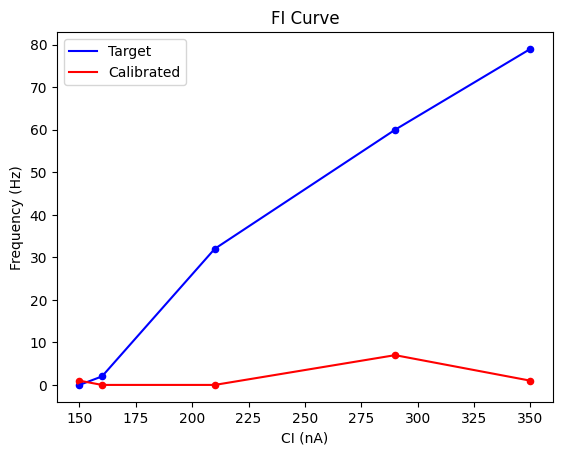

In [4]:
I = [150, 160, 210, 290, 350]

# Calibrated
simulated_data = np.load("output/SST_after_ACT/combined_out.npy")

f = []
for trace_id in range(len(simulated_data)):
    f.append(len(dp.find_events(simulated_data[trace_id, ::10, 0].flatten(), -14)))
# ---

F = [0, 2, 32, 60, 79]
plt.plot(I, F, label = "Target", c = 'blue')
plt.scatter(I, F, c = 'blue', s = 20)

# plt.plot(I, f_orig, label = "Before calibration", c = 'gray')
# plt.scatter(I, f_orig, c = 'gray', s = 20)

plt.plot(I, f, label = "Calibrated", c = 'red')
plt.scatter(I, f, c = 'red', s = 20)

plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")

plt.legend()

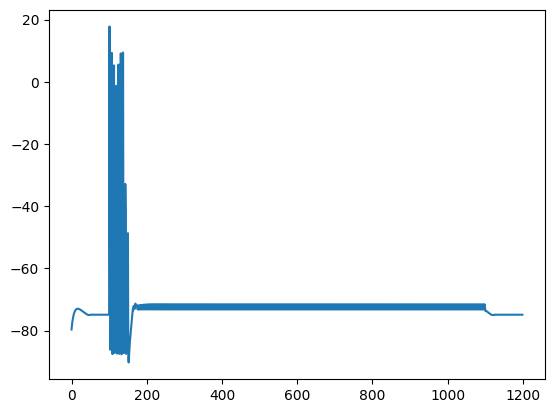

In [5]:
plt.plot(simulated_data[-2, ::10, 0])

In [1144]:
f

[0, 4, 37, 61, 78]

In [7]:
0.2224946074552039 * 1.1

0.24474406820072434